# Landfall rainfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [146]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.datasources import codab, imerg
from src.constants import *
from src import db_utils

## Load data

### Landfall dates

In [187]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7.csv"
)
landfall_df = pd.read_csv(load_path)

In [188]:
# keeping only USA_WIND as this is the most complete wind record
cols = [
    "SID",
    "SEASON",
    "NAME",
    "USA_WIND",
    "LAT",
    "LON",
    "year",
    "month",
    "day",
]

landfall_df = landfall_df[cols]

date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

# correct single negative USA_WIND
landfall_df["USA_WIND"] = landfall_df["USA_WIND"].abs()

In [189]:
landfall_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date
0,1999357S08076,2000,ASTRIDE,25.000000,-13.633333,40.466667,2000,1,3,2000-01-03
1,2000032S11116,2000,ELINE:LEONE,109.000000,-20.550000,34.750000,2000,2,22,2000-02-22
2,2000058S14063,2000,GLORIA,25.000000,-23.983333,35.433333,2000,3,9,2000-03-09
3,2000083S17102,2000,HUDAH,80.000000,-17.200000,38.300000,2000,4,8,2000-04-08
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26
5,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3,2,2003-03-02
6,2007043S11071,2007,FAVIO,93.333333,-21.900000,35.300000,2007,2,22,2007-02-22
7,2008062S10064,2008,JOKWE,94.166667,-15.983333,40.133333,2008,3,8,2008-03-08
8,2009082S16039,2009,IZILDA,15.000000,-20.200000,34.700000,2009,3,29,2009-03-29
9,2012010S24049,2012,DANDO,NaN,-24.800000,34.500000,2012,1,16,2012-01-16


### CODAB

In [6]:
adm1 = codab.load_codab(aoi_only=True)

<Axes: >

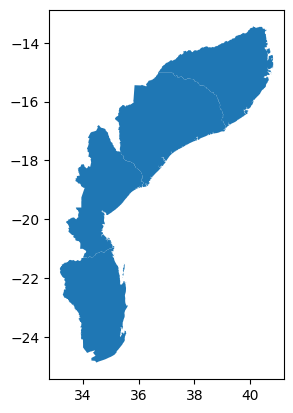

In [7]:
adm1.plot()

In [128]:
aoi_adm1_pcodes = adm1["ADM1_PCODE"].unique()

In [190]:
### IMERG

In [132]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    dfs.append(df_in)

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


In [133]:
imerg_df = pd.concat(dfs, ignore_index=True)

In [134]:
imerg_df

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,SID
0,MOZ,MZ03,2002-10-25,1,0.070872,0.000000,0.0,6.180000,2409,170.7300,0.287933,2002364S16045
1,MOZ,MZ03,2002-10-26,1,0.000434,0.000000,0.0,0.125000,2409,1.0450,0.005306,2002364S16045
2,MOZ,MZ03,2002-10-27,1,0.001399,0.000000,0.0,0.505000,2409,3.3700,0.018577,2002364S16045
3,MOZ,MZ07,2002-10-25,1,5.348575,3.250000,0.0,35.425003,2603,13922.3400,6.295778,2002364S16045
4,MOZ,MZ07,2002-10-26,1,0.473849,0.000000,0.0,22.735000,2603,1233.4299,1.644792,2002364S16045
...,...,...,...,...,...,...,...,...,...,...,...,...
271,MOZ,MZ09,2024-03-12,1,24.026690,10.934999,0.0,199.310000,2317,55669.8400,30.353436,2024071S20039
272,MOZ,MZ09,2024-03-13,1,9.223557,1.570000,0.0,114.500000,2317,21370.9790,16.398250,2024071S20039
273,MOZ,MZ11,2024-03-11,1,6.263532,1.110000,0.0,113.134995,3460,21671.8200,12.329615,2024071S20039
274,MOZ,MZ11,2024-03-12,1,4.774464,1.932500,0.0,42.820000,3460,16519.6450,6.716722,2024071S20039


In [135]:
imerg_sum_df = imerg_df.groupby(["pcode", "SID"])["mean"].sum().reset_index()
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df

,pcode,SID,sum_mean_rain
0,MZ03,2002364S16045,0.072704
1,MZ03,2003056S21042,120.842538
2,MZ03,2007043S11071,53.513980
3,MZ03,2008062S10064,5.705008
4,MZ03,2009082S16039,16.703456
...,...,...,...
83,MZ11,2022020S13059,172.006284
84,MZ11,2022065S16055,113.405056
85,MZ11,2022110S12051,17.506361
86,MZ11,2023061S22036,191.066692


## Combine data

In [136]:
combined_df = landfall_df.merge(imerg_sum_df).merge(
    adm1.rename(columns={"ADM1_PCODE": "pcode"})[["pcode", "ADM1_PT"]]
)
combined_df["nameseason"] = (
    combined_df["NAME"].str.capitalize()
    + " "
    + combined_df["year"].astype(str)
)
combined_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date,pcode,sum_mean_rain,ADM1_PT,nameseason
0,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ03,0.072704,Inhambane,Delfina 2002
1,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ07,5.913417,Nampula,Delfina 2002
2,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ09,6.525196,Sofala,Delfina 2002
3,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ11,23.723759,Zambezia,Delfina 2002
4,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3,2,2003-03-02,MZ03,120.842538,Inhambane,Japhet 2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2023061S22036,2023,FREDDY,89.333333,-17.816667,37.116667,2023,3,11,2023-03-11,MZ11,191.066692,Zambezia,Freddy 2023
88,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ03,96.246190,Inhambane,Filipo 2024
89,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ07,6.874249,Nampula,Filipo 2024
90,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ09,64.193284,Sofala,Filipo 2024


## Plot

In [138]:
def calculate_rp(group, col_name, total_seasons):
    group["rank"] = group[col_name].rank(ascending=False)
    group["rp"] = (total_seasons + 1) / group["rank"]
    return group

In [191]:
# seasons for RP calc is total seasons minus current season
total_seasons = combined_df["SEASON"].nunique() - 1

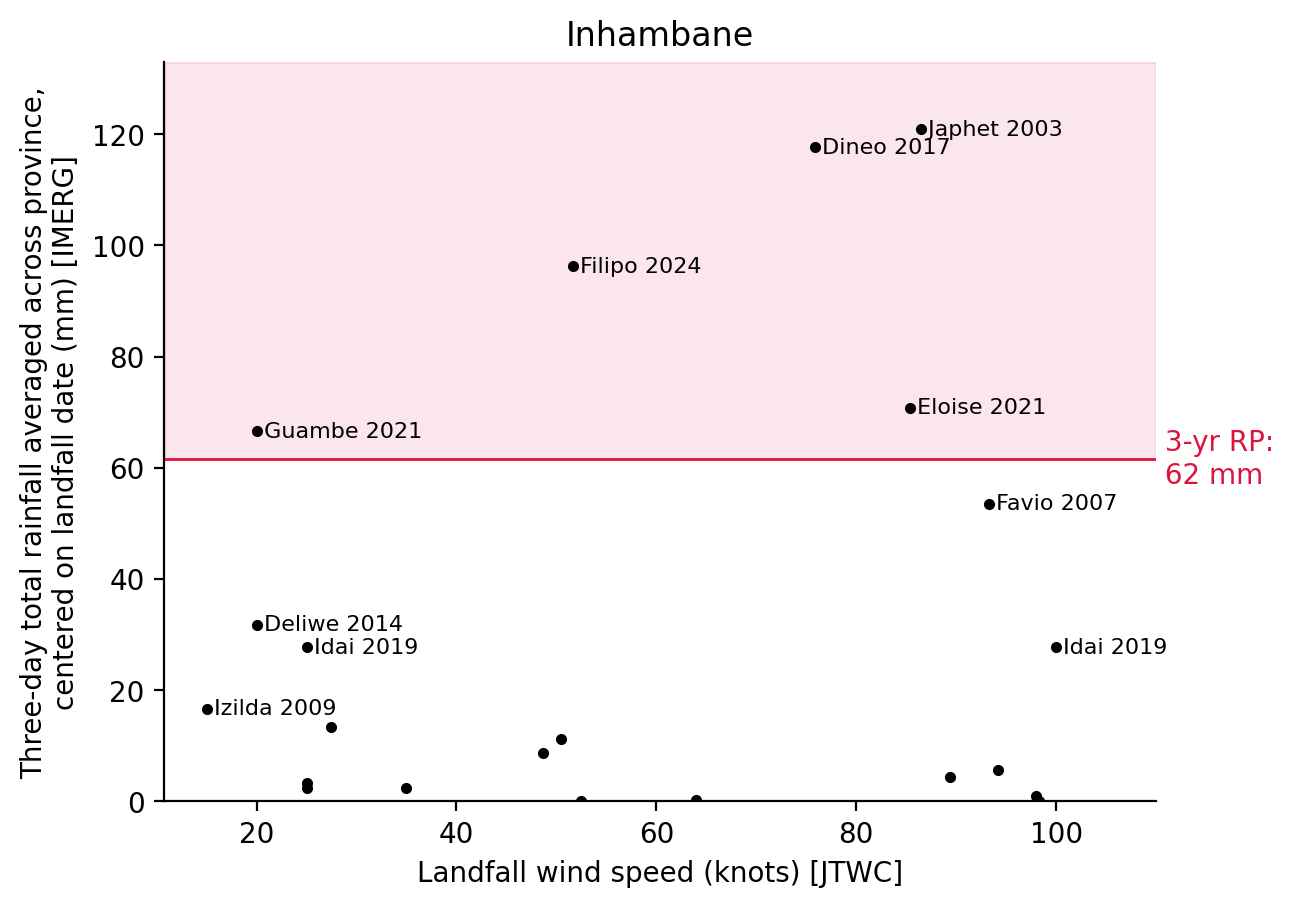

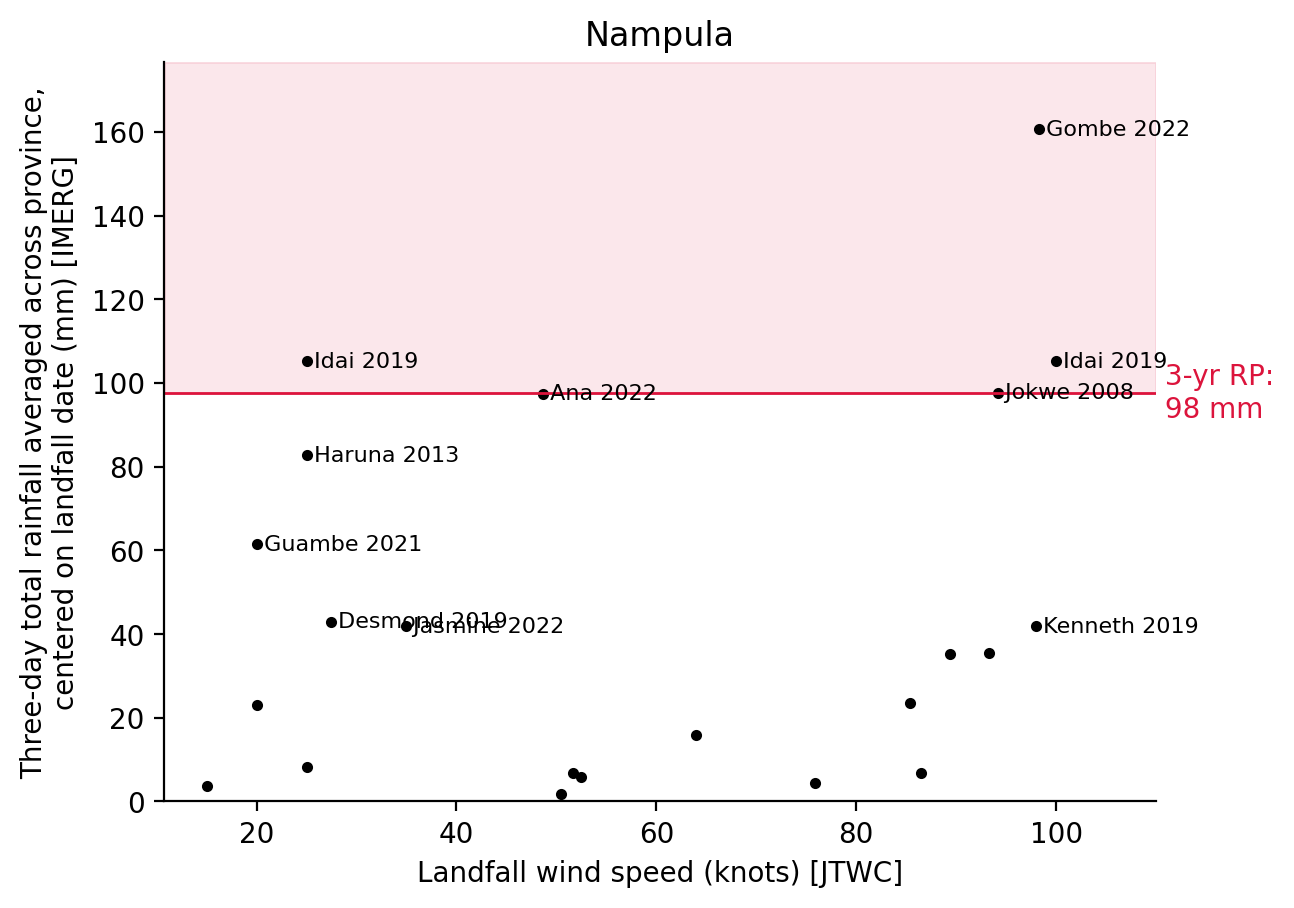

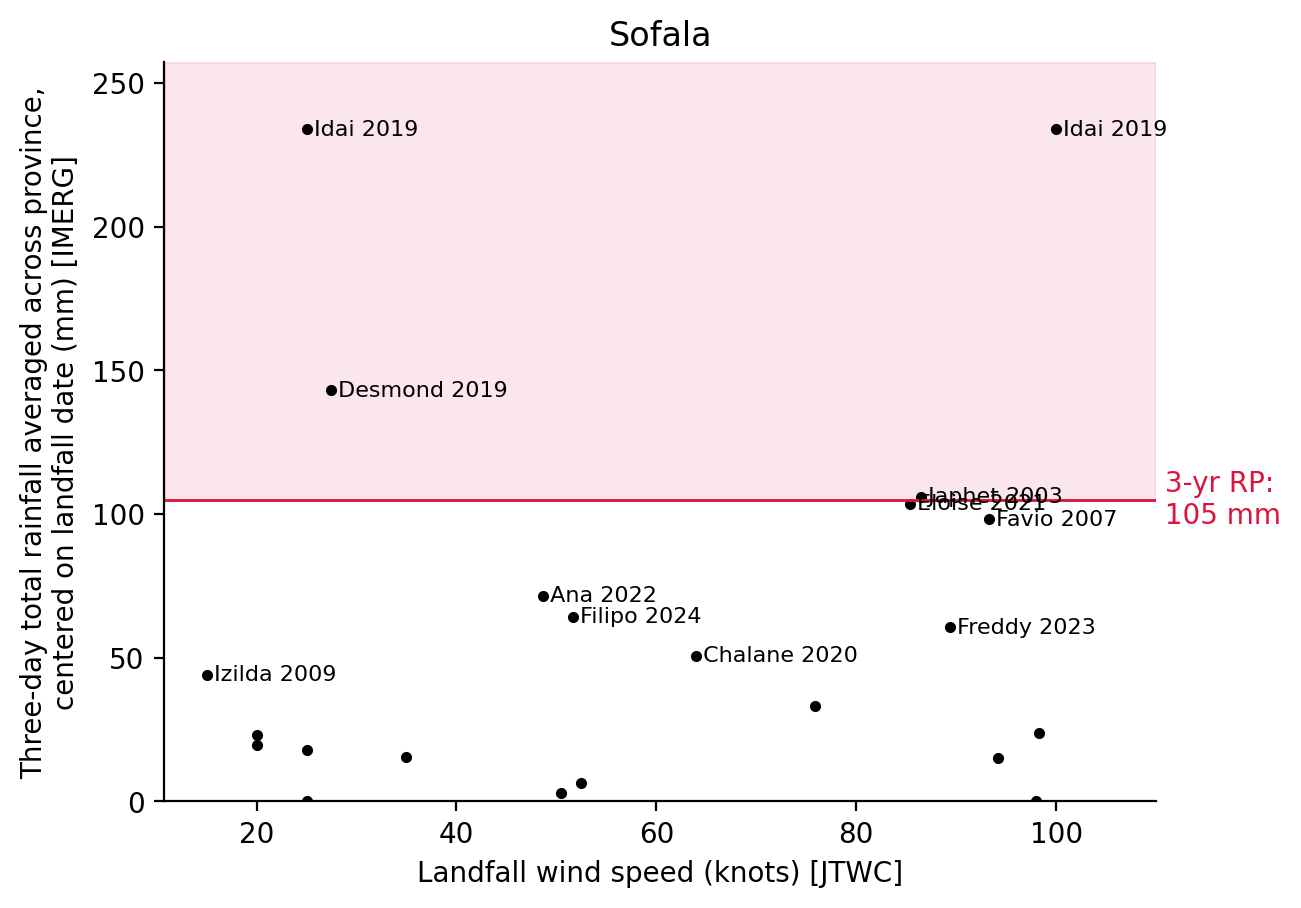

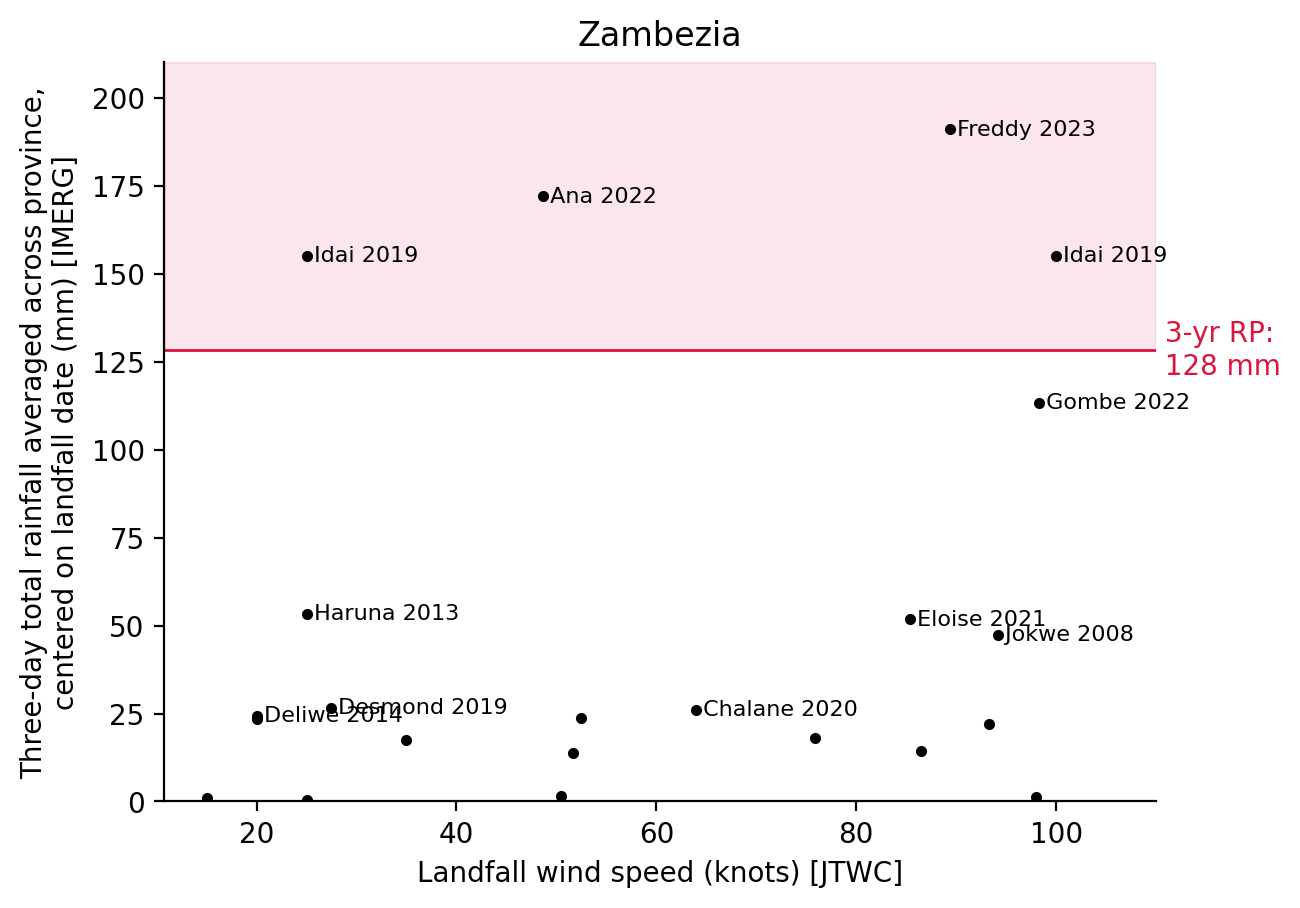

In [209]:
rp = 3
col_name = "sum_mean_rain"
color = "crimson"

for pcode, group in combined_df.groupby("pcode"):
    fig, ax = plt.subplots(dpi=200)

    # calculate RP based only on complete seasons
    dff = group[group["SEASON"] < 2024].copy()
    dff = calculate_rp(dff, col_name, total_seasons)
    dff = dff.sort_values("rp")

    # interpolate return value
    rv = np.interp(rp, dff["rp"], dff[col_name])
    top_edge = dff[col_name].max() * 1.1
    right_edge = dff["USA_WIND"].max() + 10

    group.plot(
        x="USA_WIND",
        y=col_name,
        ax=ax,
        linewidth=0,
        marker=".",
        color="k",
    )
    ax.axhline(rv, linewidth=1, color=color)
    ax.axhspan(rv, top_edge, color=color, alpha=0.1)
    ax.annotate(
        f" 3-yr RP:\n {rv:.0f} mm",
        (right_edge, rv),
        va="center",
        color=color,
    )

    # annotate high rainfall events
    for nameseason, row in group.set_index("nameseason").iterrows():
        if row[col_name] > group[col_name].median():
            ax.annotate(
                f" {nameseason}",
                (row["USA_WIND"], row[col_name]),
                fontsize=8,
                va="center",
            )

    ax.legend().remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(right=right_edge)
    ax.set_ylim(bottom=0, top=top_edge)
    ax.set_title(group.iloc[0]["ADM1_PT"])
    ax.set_xlabel("Landfall wind speed (knots) [JTWC]")
    ax.set_ylabel(
        "Three-day total rainfall averaged across province,\ncentered on landfall date (mm) [IMERG]"
    )